# Setup

In [1]:
using Plots, LinearAlgebra, DifferentialEquations, Random, Distributions, LaTeXStrings
using MonteCarloMeasurements, ComponentArrays, Unitful, StaticArrays
# plotlyjs()

# gr()

In [16]:
include("C:/Users/mjski/Desktop/Active-Work/git-projects/scripts/scripts/spacecraft_adcs.jl")

dcm_to_quaternion (generic function with 1 method)

In [2]:
Jbi = [
    66.4151 0.0 0.0
    0.0 66.4151 0.0
    0.0 0.0 116.163
]

# Jbi = [
#     3.409e10 0.0 0.0
#     0.0 3.559e10 0.0
#     0.0 0.0 4.402e10
# ] .* 1e-9

# PD controller
omega_n = 0.25
zeta = 0.8

Js = [Jbi[1,1], Jbi[2,2], Jbi[3,3]]
Kp = Js .* omega_n^2
Kd = 2 .* Js .* omega_n .* zeta

θref = [0.0, 0.0, 0.0]
ωref = [0.0, 0.0, 0.0];

In [49]:
# # thrusters
# r_th1 = [0.6, -0.2596, 0]
# r_th2 = [-0.6, -0.2596, 0]

# Th13 = 52
# Th2 = 105

# θ_thruster = π/4

# f_th11 = Th13 .* [-cos(θ_thruster), 0, -sin(θ_thruster)]
# f_th12 = Th2 .* [-1, 0, 0]
# f_th13 = Th13 .* [-cos(θ_thruster), 0, sin(θ_thruster)]

# f_th21 = Th13 .* [cos(θ_thruster), 0, -sin(θ_thruster)]
# f_th22 = Th2 .* [1, 0, 0]
# f_th23 = Th13 .* [cos(θ_thruster), 0, sin(θ_thruster)]

# M_pos_x = cross(r_th1, f_th11) + cross(r_th2, f_th21)
# M_neg_x = cross(r_th1, f_th13) + cross(r_th2, f_th23)

# M_pos_y = cross(r_th1, f_th11) + cross(r_th2, f_th23)
# M_neg_y = cross(r_th1, f_th13) + cross(r_th2, f_th21)

# M_pos_z = cross(r_th2, f_th22)
# M_neg_z = cross(r_th1, f_th12)

# # Fx = 
# # Fy = 
# # Fz = 

# Mx = norm(cross(r_th1, f_th11) + cross(r_th2, f_th21))
# My = norm(cross(r_th1, f_th11) + cross(r_th2, f_th23))
# Mz = norm(cross(r_th2, f_th22))

# Δt_min = 20e-3

# Δh_min_x = M_pos_x * Δt_min
# Δh_min_y = M_pos_y * Δt_min
# Δh_min_z = M_pos_z * Δt_min

# Δω_min_x = Δh_min_x / Js[1]
# Δω_min_y = Δh_min_y / Js[2]
# Δω_min_z = Δh_min_z / Js[3]

3-element Vector{Float64}:
 -0.0
  0.0
  0.0046930606131040005

In [3]:
function diffeq_euler(initial_conditions, time_span, params; solver_args...)
    function _differential_system!(u, p, t)
        θ1, θ2, θ3, ω1, ω2, ω3 = u        
        J1, J2, J3, M1_func, M2_func, M3_func = p
        
        SA[
            ω1,
            ω2,
            ω3,
            (M1_func(u, p, t) + (J2 - J3) * ω2 * ω3) / J1,
            (M2_func(u, p, t) + (J3 - J1) * ω1 * ω3) / J2,
            (M3_func(u, p, t) + (J1 - J2) * ω1 * ω2) / J3
        ]
    end
    
    problem = ODEProblem(_differential_system!, initial_conditions, time_span, params)
    solution = solve(problem; solver_args...)

    return solution
end

diffeq_euler (generic function with 1 method)

In [4]:
function diffeq_linear_euler(initial_conditions, time_span, params; solver_args...)
    function _differential_system!(u, p, t)
        θ1, θ2, θ3, ω1, ω2, ω3 = u        
        J1, J2, J3, M1_func, M2_func, M3_func = p
        
        SA[
            ω1,
            ω2,
            ω3,
            M1_func(u, p, t) / J1,
            M2_func(u, p, t) / J2,
            M3_func(u, p, t) / J3
        ]
    end
    
    problem = ODEProblem(_differential_system!, initial_conditions, time_span, params)
    solution = solve(problem; solver_args...)

    return solution
end

diffeq_linear_euler (generic function with 1 method)

# Simulation

In [4]:
Mx_PD(u, p, t) = Kp[1]*(θref[1] - u[1]) + Kd[1]*(ωref[1] - u[4])
My_PD(u, p, t) = Kp[2]*(θref[2] - u[2]) + Kd[2]*(ωref[2] - u[5])
Mz_PD(u, p, t) = Kp[3]*(θref[3] - u[3]) + Kd[3]*(ωref[3] - u[6])

Mz_PD (generic function with 1 method)

In [4]:
θ_deadband = [0.01, 0.01, 0.01]
ω_deadband = [0.01, 0.01, 0.01]

Mx = 0.5
My = 0.5
Mz = 0.5

# function u_bb(θ, ω, θdb, ωdb, J, T)
#     abs(θ) <= θdb && abs(ω) <= ωdb ? u = 0 : u = - T * sign(2*T / (J * θ) + ω*abs(θ))
    
#     return u
# end

function u_bb(θ, ω, θdb, ωdb, J, T; τ=1)
    abs(θ) <= θdb && abs(ω) <= ωdb ? u = 0 : u = -T * sign(θ + τ*ω)
    
    return u
end

function Mx_BB(u, p, t)
    θ1, θ2, θ3, ω1, ω2, ω3 = u        
    J1, J2, J3 = p[1], p[2], p[3]

    return u_bb(θ1, ω1, θ_deadband[1], ω_deadband[1], J1, Mx)
end

function My_BB(u, p, t)
    θ1, θ2, θ3, ω1, ω2, ω3 = u        
    J1, J2, J3 = p[1], p[2], p[3]
    
    return u_bb(θ2, ω2, θ_deadband[2], ω_deadband[2], J2, My)
end

function Mz_BB(u, p, t)
    θ1, θ2, θ3, ω1, ω2, ω3 = u        
    J1, J2, J3 = p[1], p[2], p[3]
    
    return u_bb(θ3, ω3, θ_deadband[3], ω_deadband[3], J3, Mz)
end

Mz_BB (generic function with 1 method)

In [9]:
function new_check(θ, ω, θdb, ωdb)
    return convert(Int, round(1 / (1 + exp(-(abs(θ)-θdb + abs(ω)-ωdb)))))
#     return convert(Int, 1-round((1/(1+exp(-(abs(θ)-θdb))) + 1/(1+exp(-(abs(ω)-ωdb))))))
end

# [new_check(θ_test[i], ω_test[i], θ_deadband[1], ω_deadband[1]) for i in 1:length(θ_test)]

new_check (generic function with 1 method)

In [10]:
function Mx_BB2(u, p, t)
    θ1, θ2, θ3, ω1, ω2, ω3 = u        
    J1, J2, J3 = p[1], p[2], p[3]

    return new_check(θ1, ω1, θ_deadband[1], ω_deadband[1])*((-Mx) * sign(θ1 + ω1))
end

function My_BB2(u, p, t)
    θ1, θ2, θ3, ω1, ω2, ω3 = u        
    J1, J2, J3 = p[1], p[2], p[3]
    
    return new_check(θ2, ω2, θ_deadband[2], ω_deadband[2])*((-My) * sign(θ2 + ω2))
end

function Mz_BB2(u, p, t)
    θ1, θ2, θ3, ω1, ω2, ω3 = u        
    J1, J2, J3 = p[1], p[2], p[3]
    
    return new_check(θ3, ω3, θ_deadband[3], ω_deadband[3])*((-Mz) * sign(θ3 + ω3))
end

Mz_BB2 (generic function with 1 method)

In [5]:
θ_rand = 0.1
ω_rand = 0.1

θ_deployment = rand(Uniform(-θ_rand, θ_rand), 3)
ω_deployment = rand(Uniform(-ω_rand, ω_rand), 3)

attitude_init = [
    θ_deployment[1], 
    θ_deployment[2], 
    θ_deployment[3], 
    ω_deployment[1], 
    ω_deployment[2], 
    ω_deployment[3]
]

# unsafe_comparisons(true)
# n_particles = 5
# attitude_init = [
#     0 + θ_rand * Particles(n_particles),
#     0 + θ_rand * Particles(n_particles),
#     0 + θ_rand * Particles(n_particles),
#     0 + ω_rand * Particles(n_particles),
#     0 + ω_rand * Particles(n_particles),
#     0 + ω_rand * Particles(n_particles)
# ]

# attitude_init = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# init that gives decent results
# attitude_init = [
#      -0.38495040270524206,
#      -0.06740167143231446,
#      -0.12004445998798918,
#       0.022167514727417,
#       0.04211541006862213,
#       0.07809182423448416
# ]

attitude_tspan = (0.0, 5*60.0)

# attitude_params = [Js[1], Js[2], Js[3], Mx_PD, My_PD, Mz_PD]

attitude_params = [Js[1], Js[2], Js[3], Mx_BB, My_BB, Mz_BB]

# attitude_params = [Js[1], Js[2], Js[3], Mx_BB2, My_BB2, Mz_BB2]

# lower tolerances result in screwed up results
attitude_sol = diffeq_euler(
    attitude_init, attitude_tspan, attitude_params,
    reltol=5e-6, abstol=5e-6
);

# attitude_sol = diffeq_linear_euler(
#     attitude_init, attitude_tspan, attitude_params, 
#     reltol=1e-10, abstol=1e-10
# );

In [6]:
times = LinRange(0.0, attitude_tspan[2], 5000)
# times = LinRange(0.0, 5*60.0, 5000)
sol_interp = attitude_sol(times)

theta_1 = sol_interp[1, 1:end]
theta_2 = sol_interp[2, 1:end]
theta_3 = sol_interp[3, 1:end]

omega_1 = sol_interp[4, 1:end]
omega_2 = sol_interp[5, 1:end]
omega_3 = sol_interp[6, 1:end];

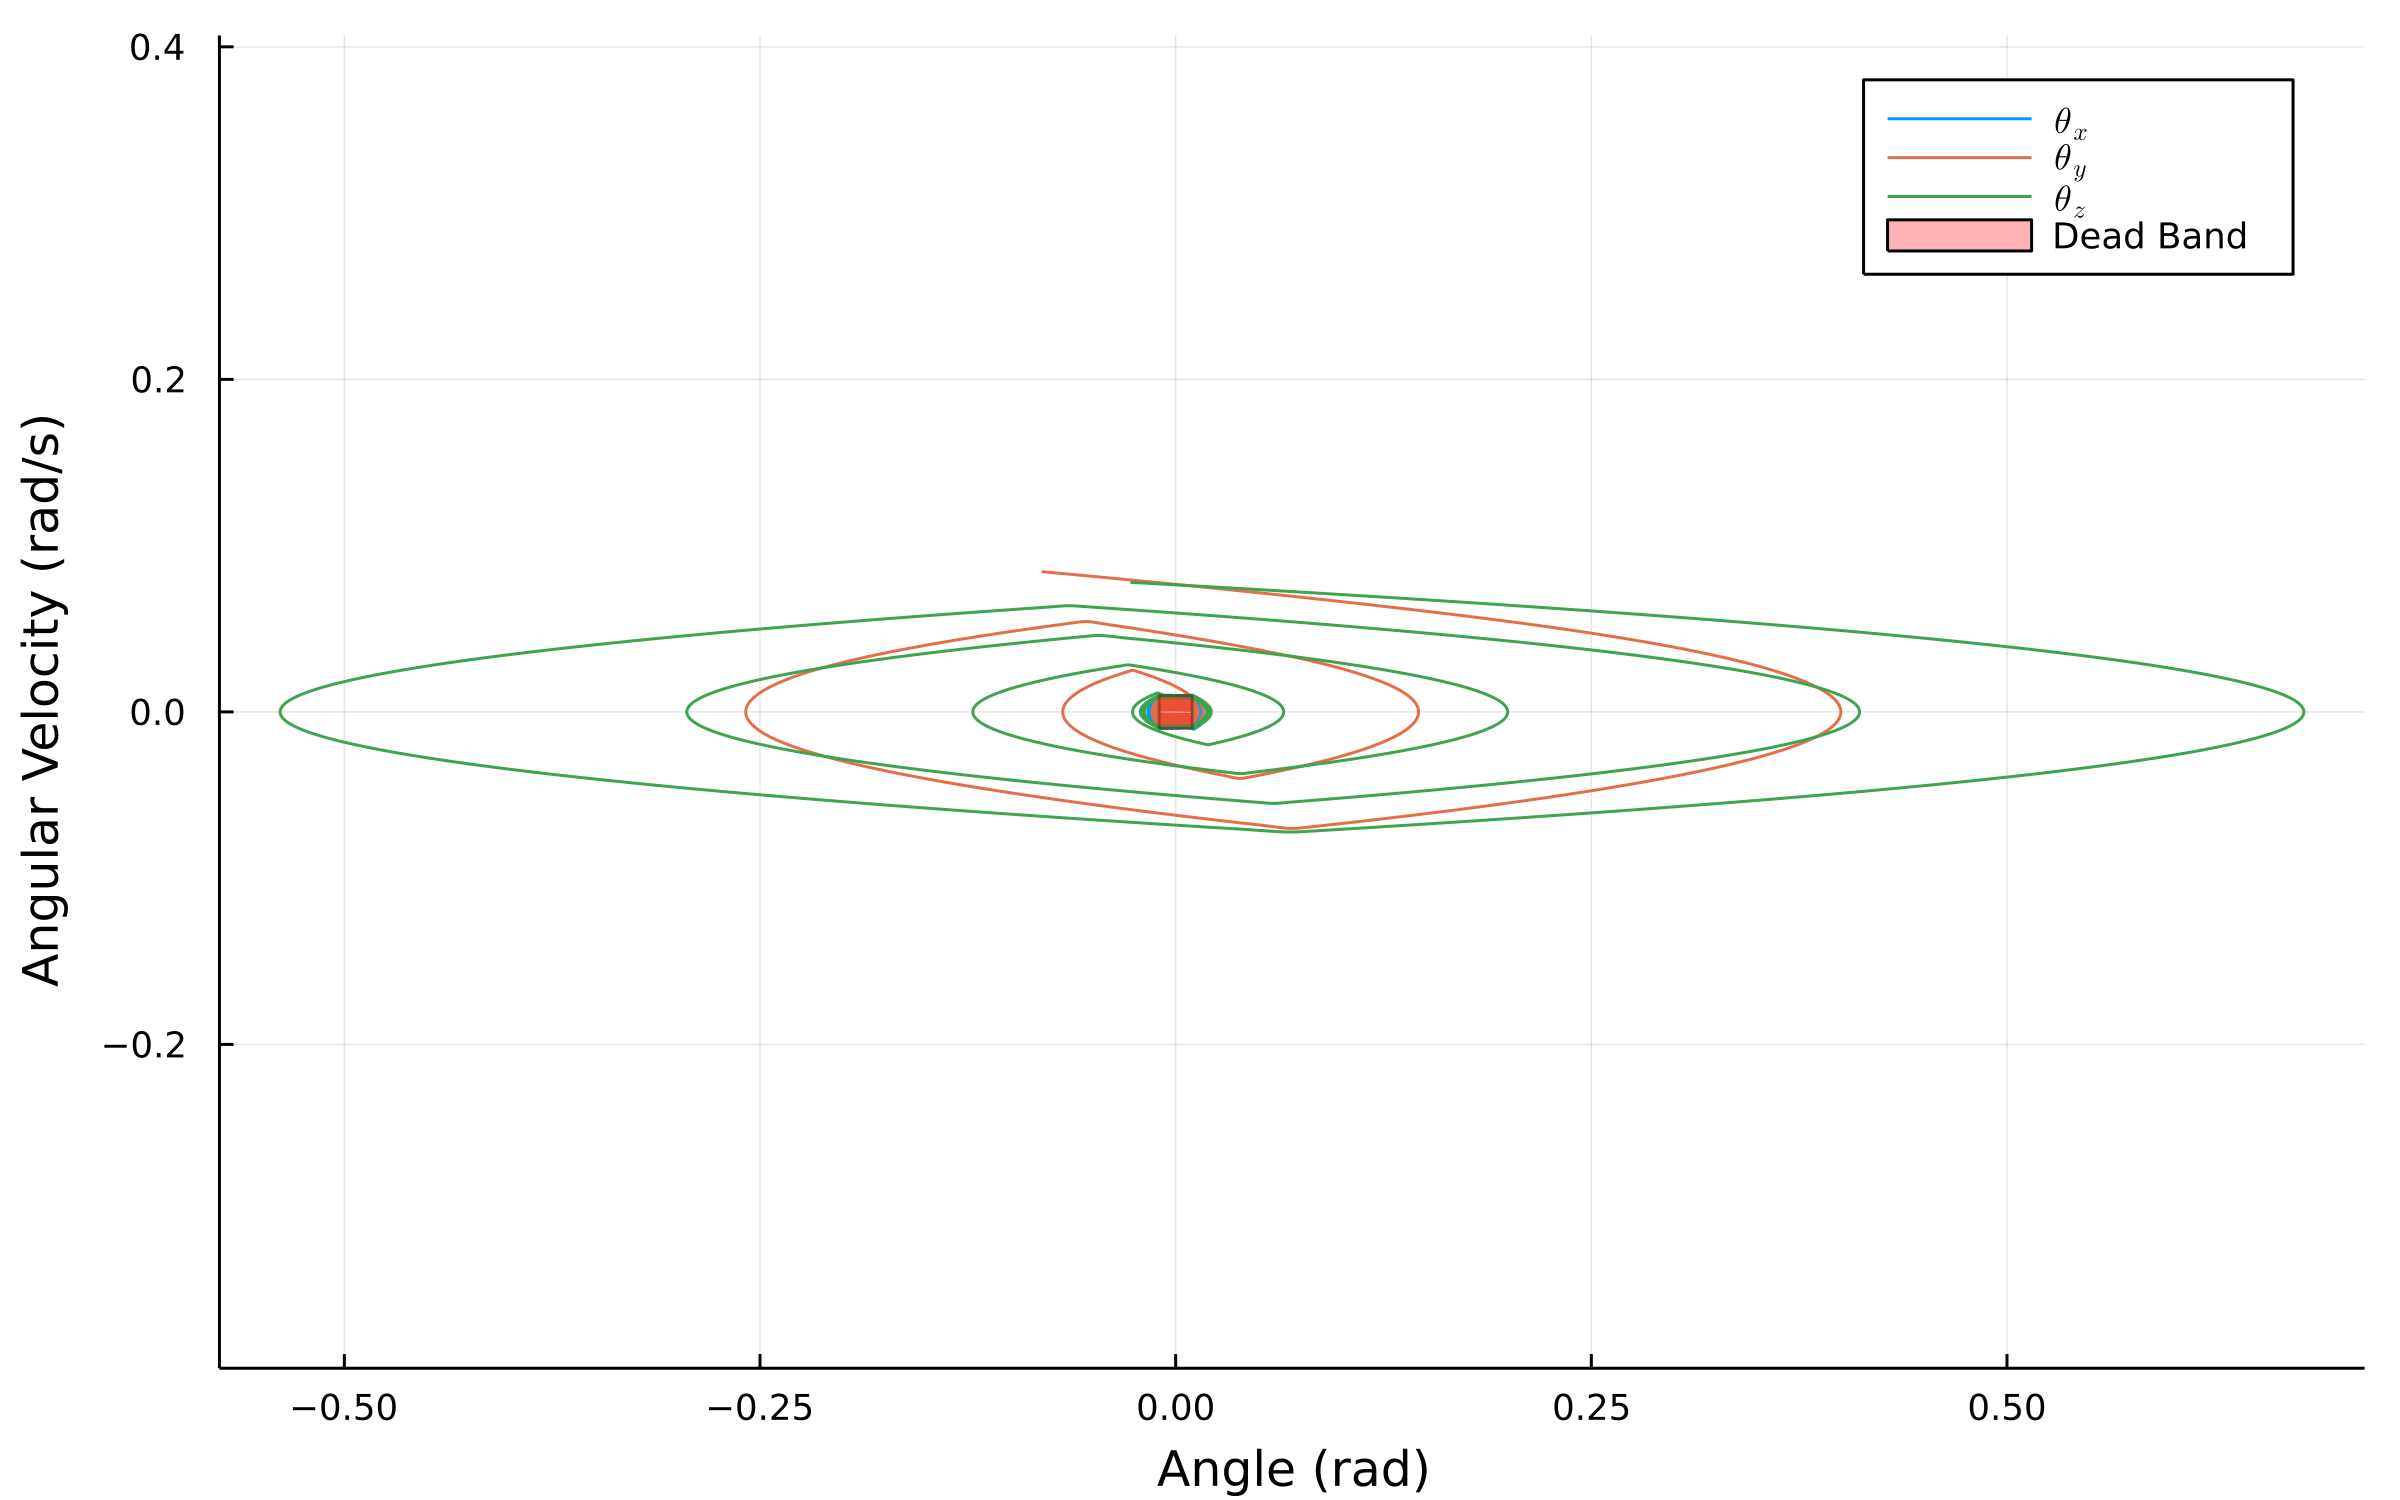

In [9]:
plot(
    theta_1, omega_1, 
    label=L"\theta_x", 
    aspect_ratio=:equal, 
    xlabel="Angle (rad)", 
    ylabel="Angular Velocity (rad/s)",
    size=(800,500),
    dpi=300,
    fmt=:png
)

plot!(theta_2, omega_2, label=L"\theta_y")
plot!(theta_3, omega_3, label=L"\theta_z")

db = Shape([
    (-θ_deadband[1], -ω_deadband[1]), 
    (-θ_deadband[1], ω_deadband[1]), 
    (θ_deadband[1], ω_deadband[1]), 
    (θ_deadband[1], -ω_deadband[1])
])

plot!(db, opacity=.3, color=:red, label="Dead Band")

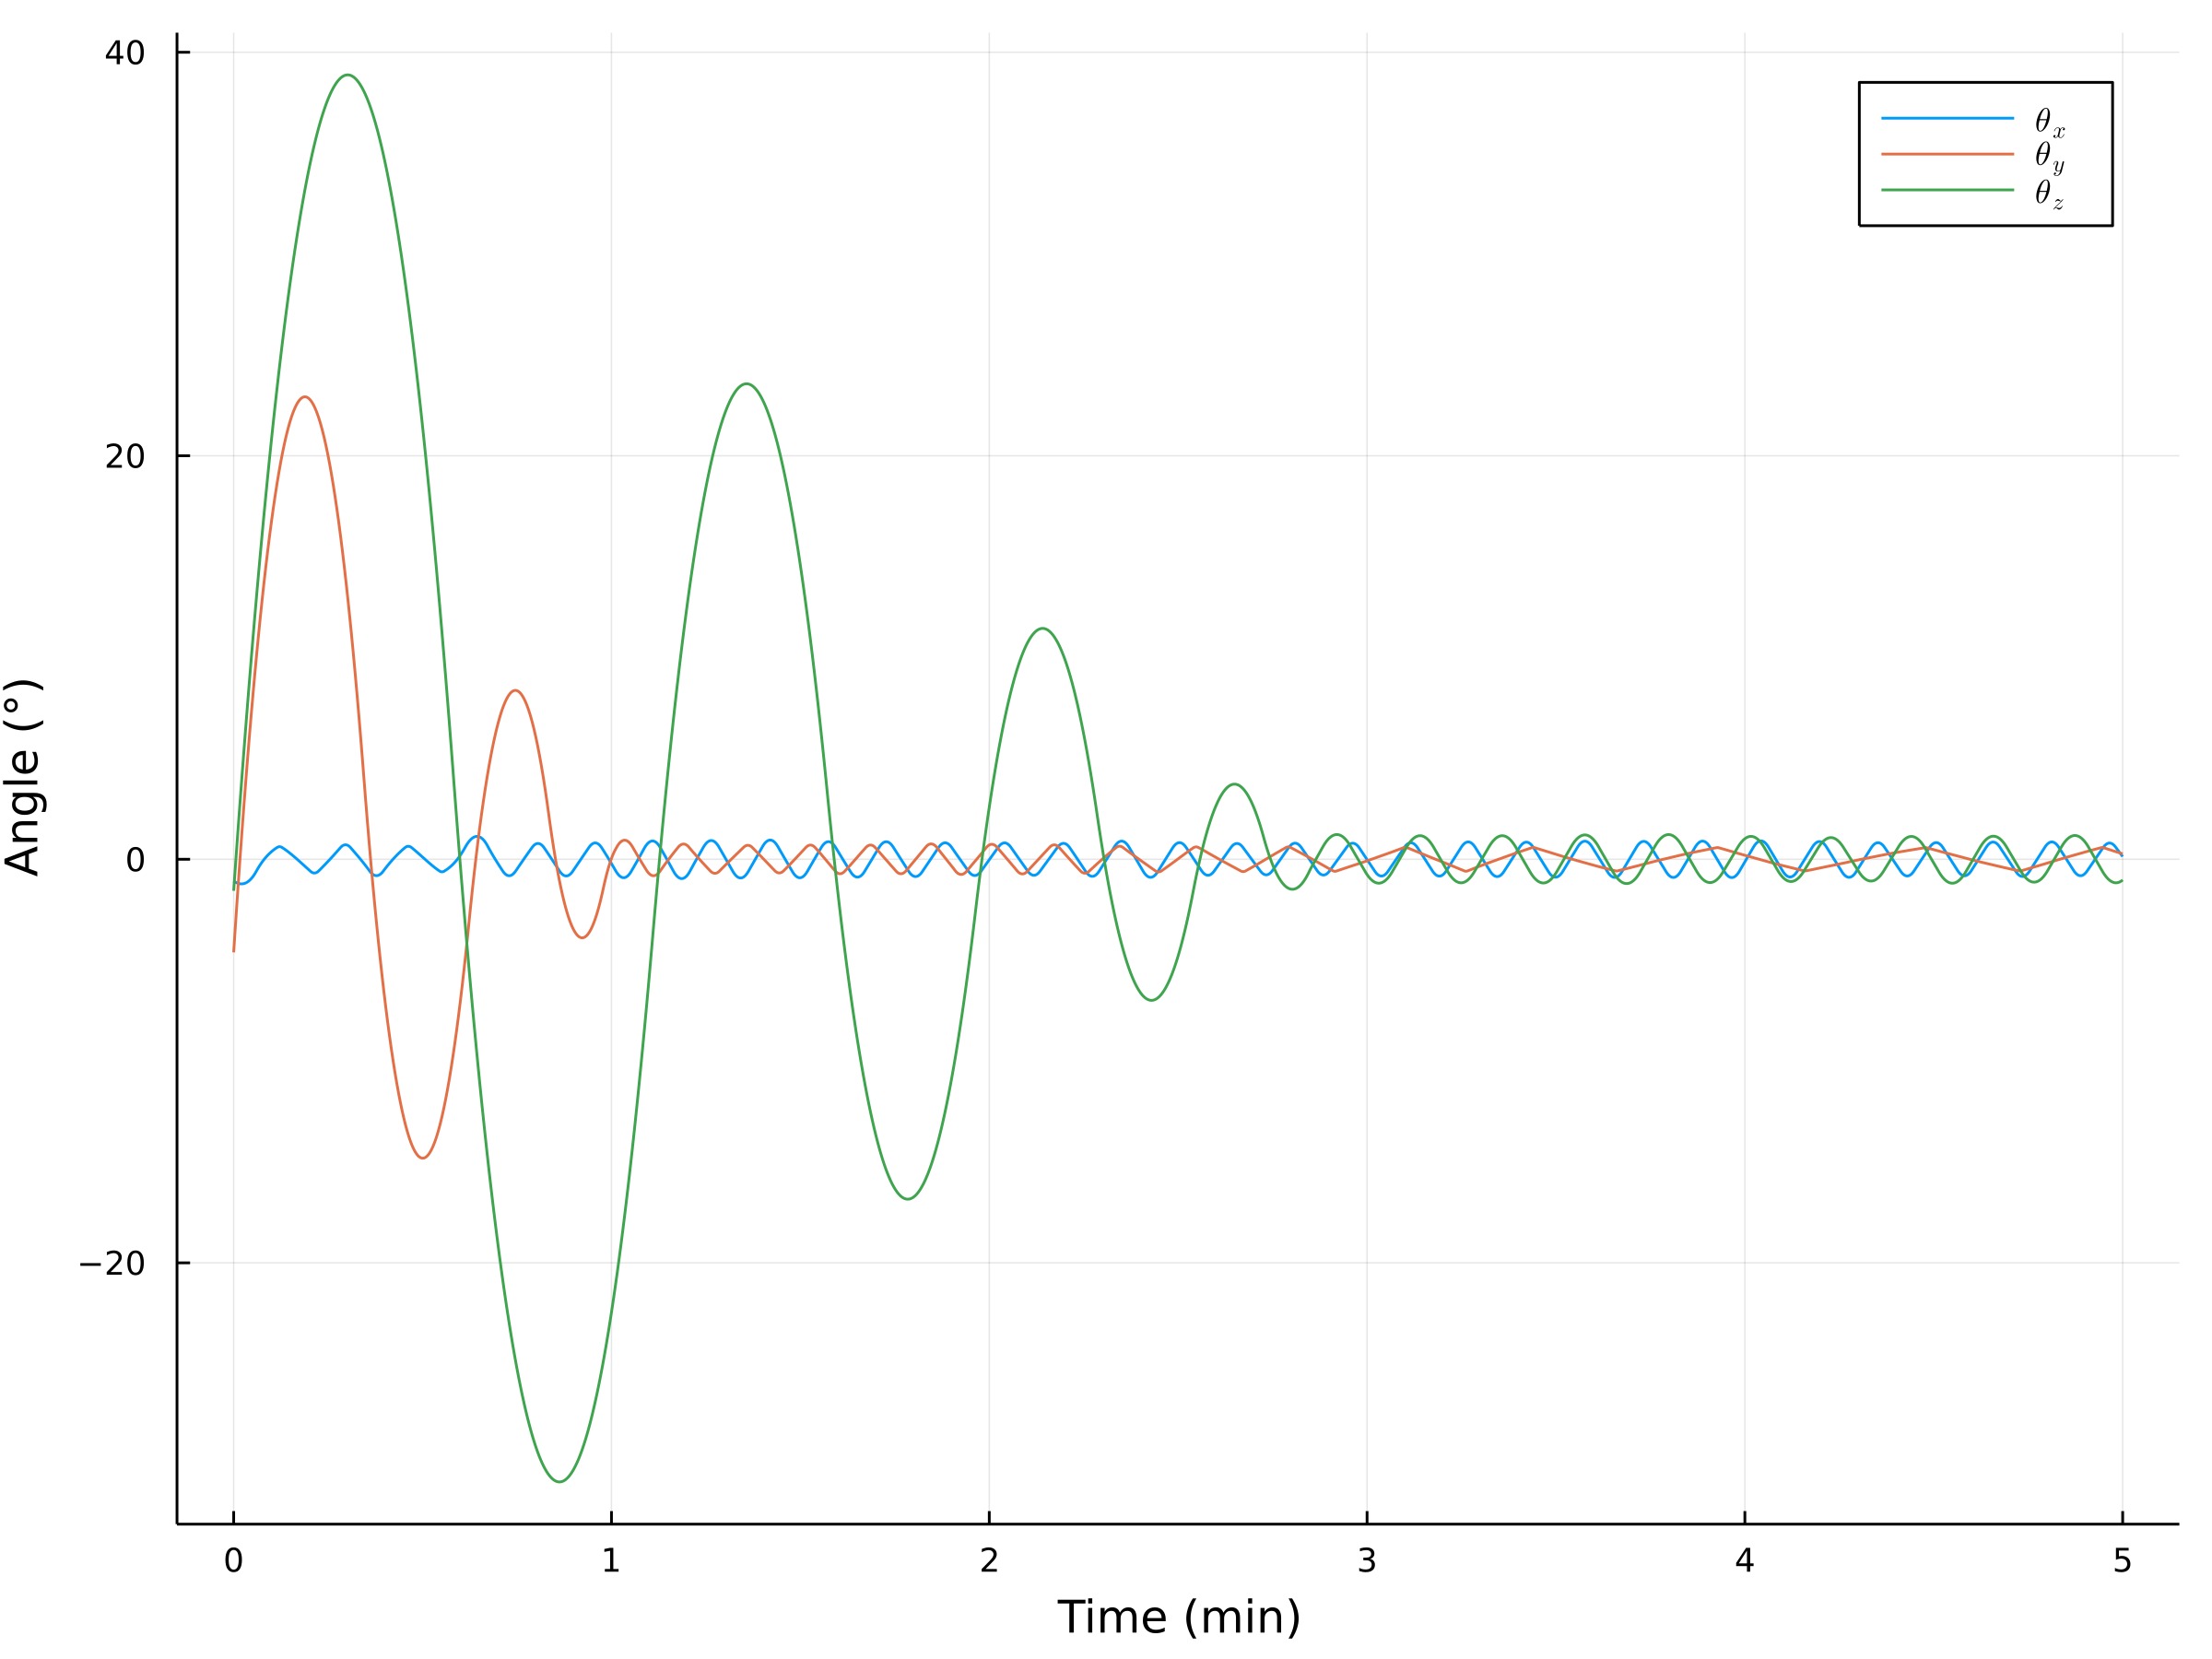

In [30]:
plot(
    times ./ 60, rad2deg.(theta_1), 
    label=L"\theta_x", 
    xlabel="Time (min)", 
    ylabel="Angle (°)", 
    legend=:topright,
    size=(800,600),
    dpi=300,
    fmt=:png
)

plot!(times ./ 60, rad2deg.(theta_2), label=L"\theta_y")
plot!(times ./ 60, rad2deg.(theta_3), label=L"\theta_z")

In [14]:
# plot(theta_1[3000:end])
rad2deg(maximum(theta_1[3000:end])), rad2deg(minimum(theta_1[3000:end]))

(0.9105776153836521, -0.9055658837797669)

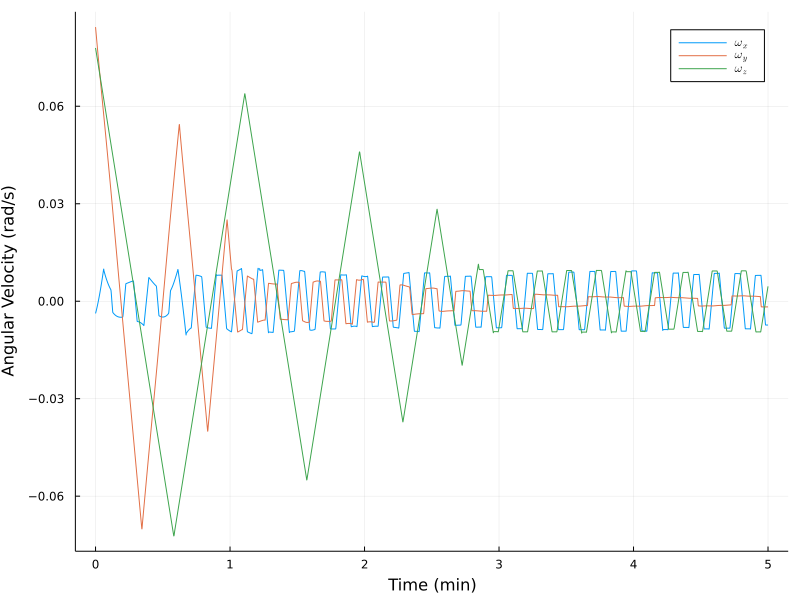

In [11]:
plot(
    times ./ 60, omega_1, 
    label=L"\omega_x", 
    xlabel="Time (min)", 
    ylabel="Angular Velocity (rad/s)", 
    legend=:topright,
    size=(800,600),
    dpi=300
)

plot!(times ./ 60, omega_2, label=L"\omega_y")
plot!(times ./ 60, omega_3, label=L"\omega_z")

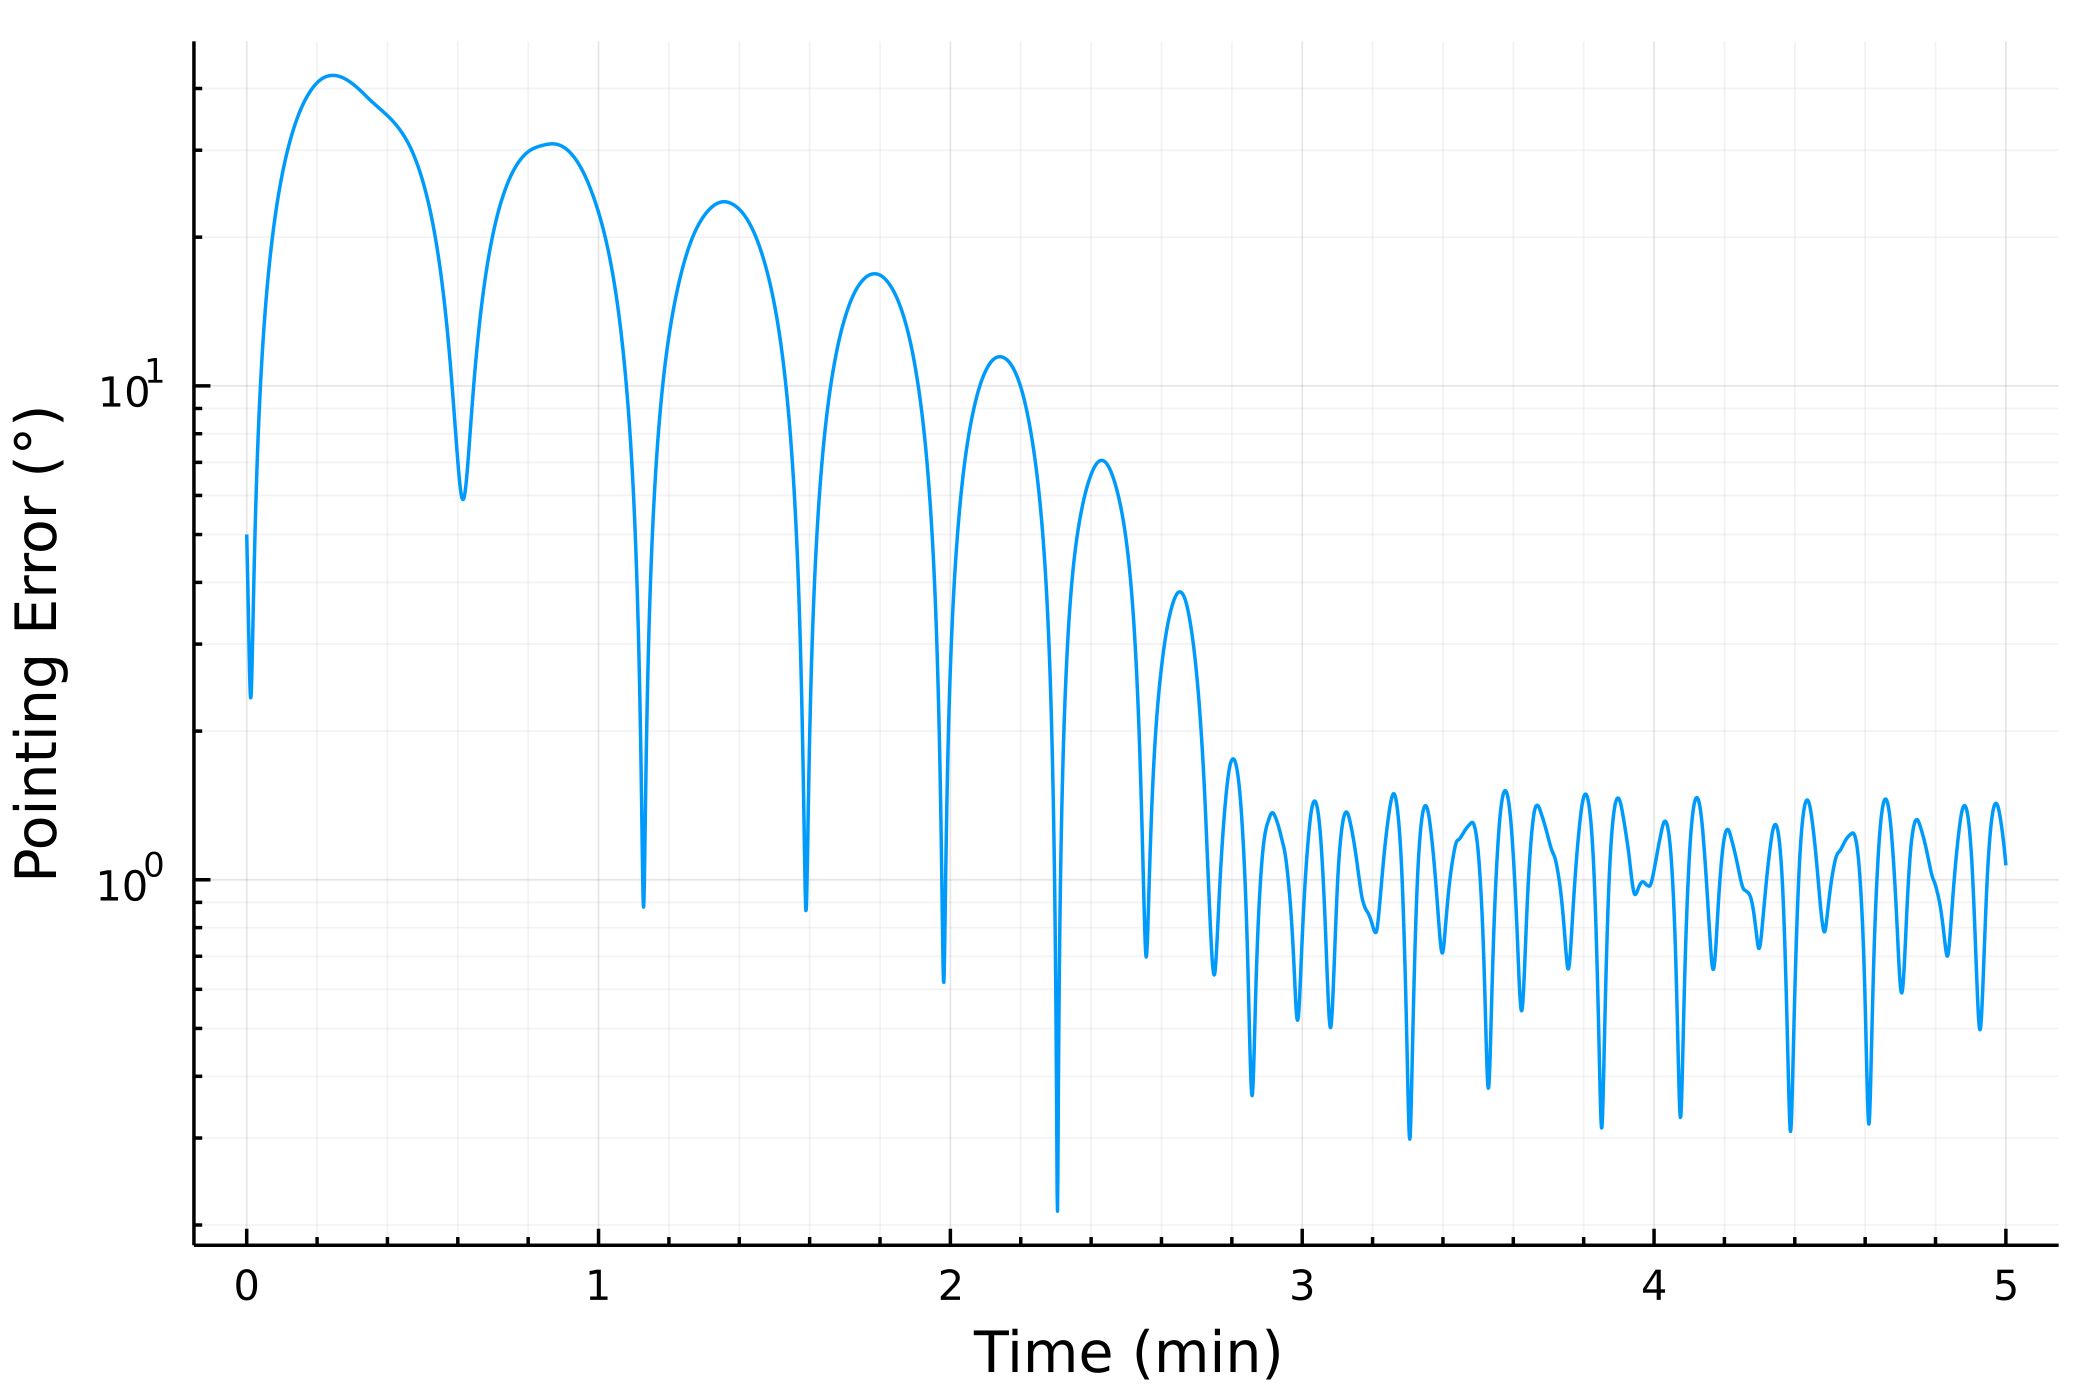

In [24]:
# testing pointing accuracy
function dcm_deviation(C, C_true)
    CN = C * C_true'
    return acos(0.5 * (trace(CN) - 1))
end

function C_LVLH_B(θ1, θ2, θ3)
    return par_1(θ1) * par_2(θ2) * par_3(θ3)
end

C_LB = C_LVLH_B.(theta_1, theta_2, theta_3)

pointing_error = [dcm_deviation(C, I(3)) for C in C_LB]

plot(
    times ./ 60, rad2deg.(pointing_error), 
    label="", 
    yaxis=:log, 
    minorgrid=true,
    xlabel="Time (min)",
    ylabel="Pointing Error (°)",
    size=(600,400),
    dpi=350,
    fmt=:png
)

In [28]:
rad2deg(mean(pointing_error[3000:end]))

1.0368916547930969

# Archive

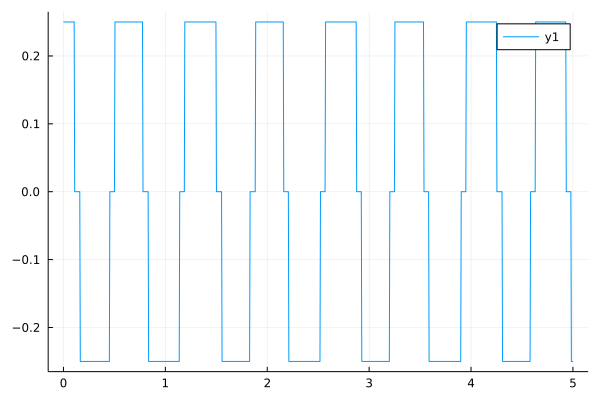

In [182]:
ux = [u_bb(theta_1[i], omega_1[i], θ_deadband[1], ω_deadband[1], Js[1], Mx) for i in 1:length(theta_1)]
plot(times ./ 60, ux)

In [269]:
function diffeq_euler_oneaxis(initial_conditions, time_span, params; solver_args...)
    function _differential_system!(u, p, t)
        θ, ω = u
        J, M_func = p
        
        SA[
            ω,
            M_func(u, p, t) / J
        ]
    end
    
    problem = ODEProblem(_differential_system!, initial_conditions, time_span, params)
    solution = solve(problem; solver_args...)

    return solution
end

function M_BB(u, p, t)
    θ, ω = u        
    J = p[1]

    return u_bb(θ, ω, θ_deadband[1], ω_deadband[1], J, Mx)
end

function M_BB2(u, p, t)
    θ, ω = u        
    J = p[1]

    return u_bb2(θ, ω, θ_deadband[1], ω_deadband[1], J, Mx)
end

M_BB2 (generic function with 1 method)

In [279]:
u0_oneaxis = [
     -0.38495040270524206,
      0.022167514727417,
]

p_oneaxis = [Js[1], M_BB2]

sol_oneaxis = diffeq_euler_oneaxis(
    u0_oneaxis, attitude_tspan, p_oneaxis, 
    reltol=1e-10, abstol=1e-10
);

In [280]:
sol_oa_interp = sol_oneaxis(times)
θ_oa = sol_oa_interp[1, 1:end]
ω_oa = sol_oa_interp[2, 1:end];

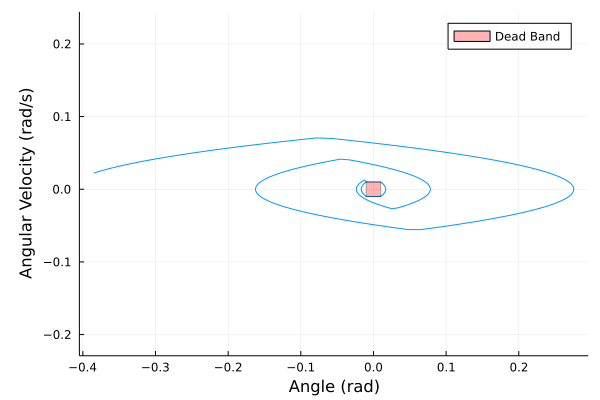

In [281]:
plot(
    θ_oa, ω_oa, 
    label="", 
    aspect_ratio=:equal, 
    xlabel="Angle (rad)", 
    ylabel="Angular Velocity (rad/s)"
)

db = Shape([
    (-θ_deadband[1], -ω_deadband[1]), 
    (-θ_deadband[1], ω_deadband[1]), 
    (θ_deadband[1], ω_deadband[1]), 
    (θ_deadband[1], -ω_deadband[1])
])

plot!(db, opacity=.3, color=:red, label="Dead Band")

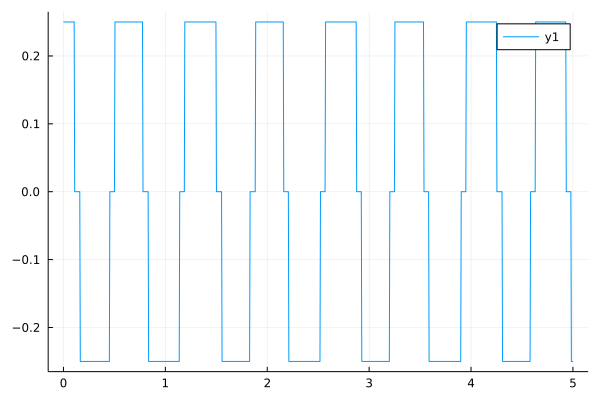

In [282]:
u_oa = [u_bb(θ_oa[i], ω_oa[i], θ_deadband[1], ω_deadband[1], Js[1], Mx) for i in 1:length(θ_oa)]
plot(times ./ 60, ux)

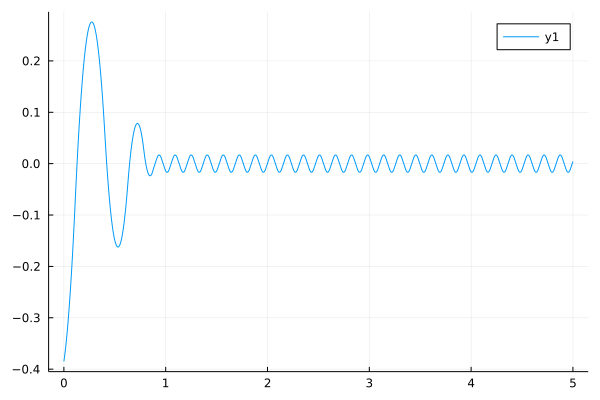

In [284]:
plot(times ./ 60, θ_oa)
# plot!(times ./ 60, ux)

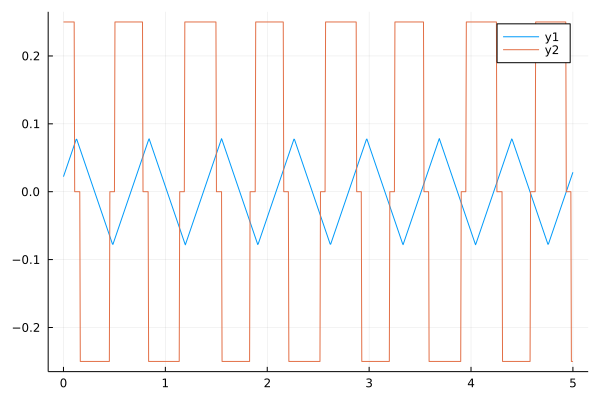

In [261]:
plot(times ./ 60, ω_oa)
plot!(times ./ 60, ux)

In [14]:
mcplot(times, theta_1, label=L"\theta_x", size=(800,600), dpi=300)
mcplot!(times, theta_2, label=L"\theta_y")
mcplot!(times, theta_3, label=L"\theta_z")

# plot(fig1, fig2, fig3, layout=(3,1), size=(800,800), dpi=300)

# fig2 = mcplot(
#     times ./ 60, omega_1, 
#     label="ωx", 
#     xlabel="Time (min)", 
#     ylabel="Angular Velocity (rad/s)", 
#     legend=:topright
# )

# mcplot!(times ./ 60, omega_2, label="ωy")
# mcplot!(times ./ 60, omega_3, label="ωz")

# plot(fig1, fig2, layout=(2,1), size=(800, 800), dpi=300)

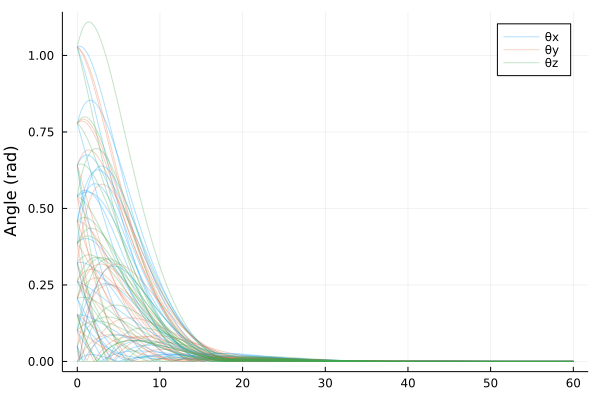

In [65]:
fig1 = mcplot(
    times, abs.(theta_1 .- θref[1]), 
    label="θx", 
    ylabel="Angle (rad)", 
    legend=:topright
)

mcplot!(times, abs.(theta_2 .- θref[2]), label="θy")
mcplot!(times, abs.(theta_3 .- θref[3]), label="θz")